# DAY 1 EDA

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
train_path = "/opt/ml/input/data/train"

<h2> csv 살펴보기 </h2>

- null 값은 일단 하나도 없는 것을 확인
- id, gender, race, age, path 5개의 column이고 데이터 수는 2700개임

In [3]:
train_csv = pd.read_csv(os.path.join(train_path, 'train.csv'))
train_csv.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [4]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


<h2> 중복 ID 003397발견 </h2>

- 이미지를 열어 중복된 데이터인지 확인
- 다행히 아이디만 중복이였음
- 추후 알게 되겠지만 여기서 이미지 픽셀도 파악함

In [5]:
train_csv.describe(include='all')

,id,gender,race,age,path
count,2700,2700,2700,2700.000000,2700
unique,2699,2,1,NaN,2700
top,003397,female,Asian,NaN,000741_female_Asian_50
freq,2,1658,2700,NaN,1
mean,NaN,NaN,NaN,37.708148,NaN
std,NaN,NaN,NaN,16.985904,NaN
min,NaN,NaN,NaN,18.000000,NaN
25%,NaN,NaN,NaN,20.000000,NaN
50%,NaN,NaN,NaN,36.000000,NaN
75%,NaN,NaN,NaN,55.000000,NaN


이미지 크기: (384, 512)


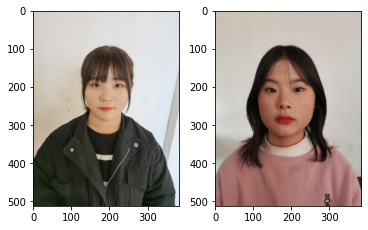

In [6]:
pil_img_3397_01 = Image.open("/opt/ml/input/data/train/images/003397_female_Asian_19/normal.jpg")
pil_img_3397_02 = Image.open("/opt/ml/input/data/train/images/003397_female_Asian_20/normal.jpg")
fig, axes = plt.subplots(1, 2, figsize=(5, 4), constrained_layout=True )
axes[0].imshow(pil_img_3397_01)
axes[1].imshow(pil_img_3397_02)
print("이미지 크기: {}".format(pil_img_3397_01.size))

<h2> 나이대 분석 </h2>

- 예측 해야 할 나이대의 분류는 3가지 (30미만, 30이상60미만, 60이상)
- 60살 이상의 데이터가 다른 데이터에 비해 많이 부족함
- 1살 단위로 나이 분포도 그려봄 20살, 60살 주변에 데이터가 많은 것을 확인
- train 데이터 최대 나이가 60인데, 범주가 60이상이라 60세이신 분들이 많아도 범주로 묶어서 보면 비율이 낮아짐

In [7]:
train_csv.loc[train_csv["age"] < 30, "age_band"] = "age<30"
train_csv.loc[(train_csv["age"]>=30) & (train_csv["age"]<60), "age_band"] = "30<=age<60"
train_csv.loc[train_csv["age"] >= 60, "age_band"] = "60<=age"
group_age_band = train_csv["age_band"].value_counts()
group_age = train_csv["age"].value_counts()
group_age_band

age<30        1281
30<=age<60    1227
60<=age        192
Name: age_band, dtype: int64

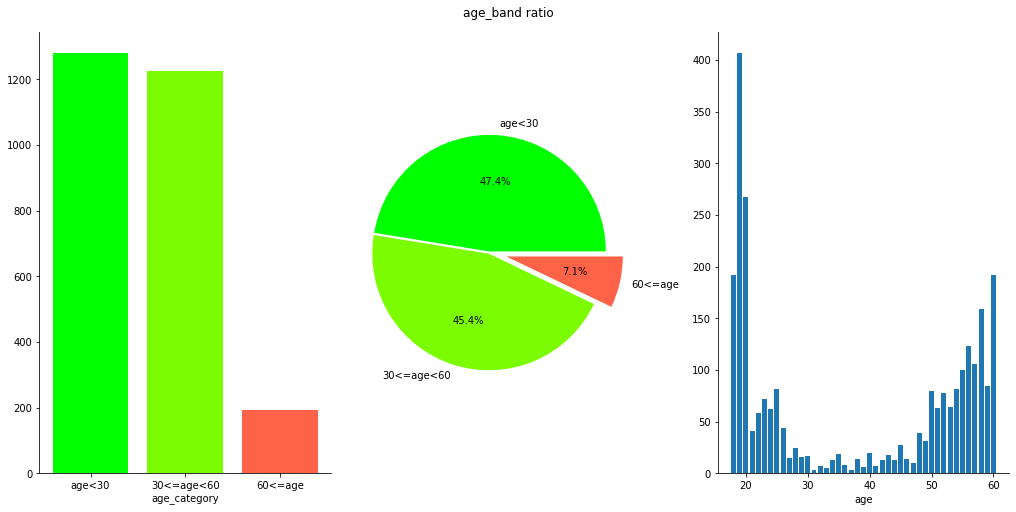

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(14, 7), constrained_layout=True )
fig.suptitle("age_band ratio")
colors = ["lime", "lawngreen","tomato"]
axes[0].bar(group_age_band.index,group_age_band, color = colors)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlabel("age_category")
explode = [0.01,0.01,0.15]
axes[1].pie(group_age_band/ 2700, labels = group_age_band.index,colors= colors, autopct='%.1f%%', explode=explode)
axes[2].bar(group_age.index,group_age, )
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlabel("age")
plt.show()

<h2> 성비 분석 </h2>

- 성비는 비슷하게 나옴

In [9]:
group_gender = train_csv["gender"].value_counts()
group_gender

female    1658
male      1042
Name: gender, dtype: int64

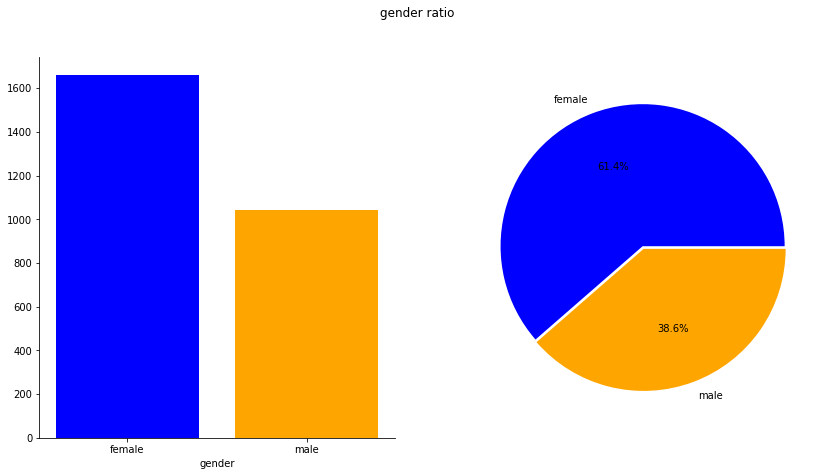

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
colors = ["blue", "orange"]
fig.suptitle("gender ratio")
axes[0].bar(group_gender.index,group_gender, color = colors)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlabel("gender")
explode = [0.01,0.01]
axes[1].pie(group_gender/ 2700, labels = group_gender.index, colors = colors, autopct='%.1f%%', explode= explode)
plt.show()

<h2> 성별 연령 묶어서 보기 </h2>

- 30~60 세의 여성이 가장 많은 데이터를 차지하고 있고 60세 이상의 남성이 가장 적은 데이터를 차지하고 있음

In [11]:
for i in group_gender.index:
    for j in group_age_band.index:
        train_csv.loc[(train_csv["age_band"] == j) & (train_csv["gender"] == i), "age_band & gender"] = "{},{}".format(i,j)

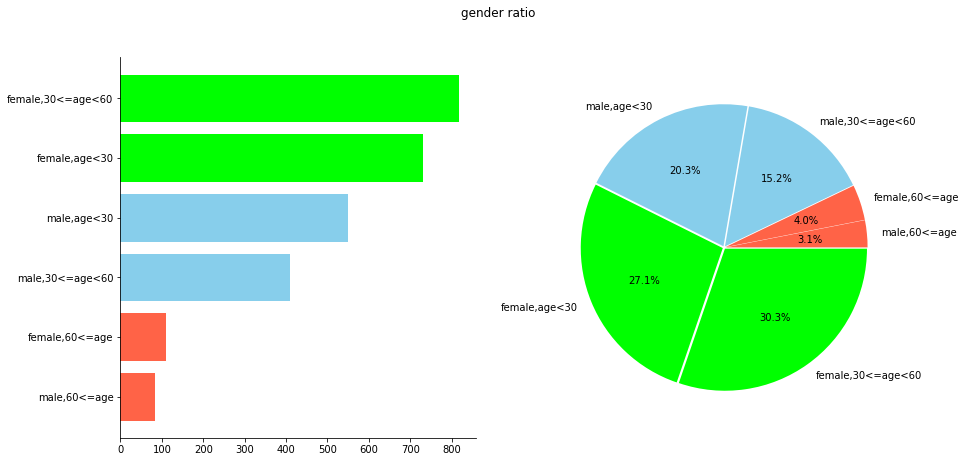

In [40]:
group_ageband_gender = train_csv["age_band & gender"].value_counts().sort_values(ascending = True)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle("gender ratio")
colors = ["tomato","tomato","skyblue","skyblue","lime","lime"]
axes[0].barh(group_ageband_gender.index, group_ageband_gender, color = colors)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
explode = [0.01]*6
axes[1].pie(group_ageband_gender/ 2700, labels = group_ageband_gender.index, autopct='%.1f%%',colors =colors, explode= explode)
plt.show()

# TODO

남녀랑 나이 같이 그린 그래프 추가하는게 더 보여주기 편할듯

<h2> 파일 쉽게 읽기 위한 데이터 프로세싱</h2>

- 한 김에 분류하고자 하는 클래스의 테스트 셋에서의 분포 보기
- 데이터 프레임 생성에 시간이 좀 걸림
- csv 파일로 저장 후 불러오는 방식 채택

<h2> 학습용 df 만들기 (각 이미지 경로, 라벨) </h2>

- 아래는 data frame을 만드는 코드다 생성하여

```python
train_df = pd.DataFrame(None, columns = ['path', 'mask_state', 'age_band', 'gender','label'])
gender_num_dict =  {"male": 0, "female": 1}
ageband_num_dict =  {"age<30": 0, "30<=age<60": 1,"60<=age": 2}
for index, line in enumerate(train_csv.iloc):
    for file in list(os.listdir(os.path.join(train_path,"images", line['path']))):
        if file[0] == '.':
            continue
        if file.split('.')[0] == 'normal':
            mask = 2
        elif file.split('.')[0] == 'incorrect_mask':
            mask = 1
        else:
            mask = 0
        data = {
            'path': os.path.join(train_path,"images",line['path'], file),
            'mask_state': mask,
            'age_band': ageband_num_dict[line['age_band']],
            'gender': gender_num_dict[line['gender']],
            'label':mask * 6 + gender_num_dict[line['gender']] * 3 + ageband_num_dict[line['age_band']]
        }
        train_df = train_df.append(data, ignore_index=True)
train_df.head()
```

In [13]:
train_df = pd.read_csv("/opt/ml/path_csv/image_path_label.csv")

In [14]:
def label_to_info(label_index):
    return "{}, {}, {}".format({0:"wear",1:"incorrect",2:"normal"}[label_index//6],
                                       {0:"0~29",1:"30~59",2:"60~"}[label_index%6%3],
                                       {0:"male",1:"female"}[label_index%6//3])

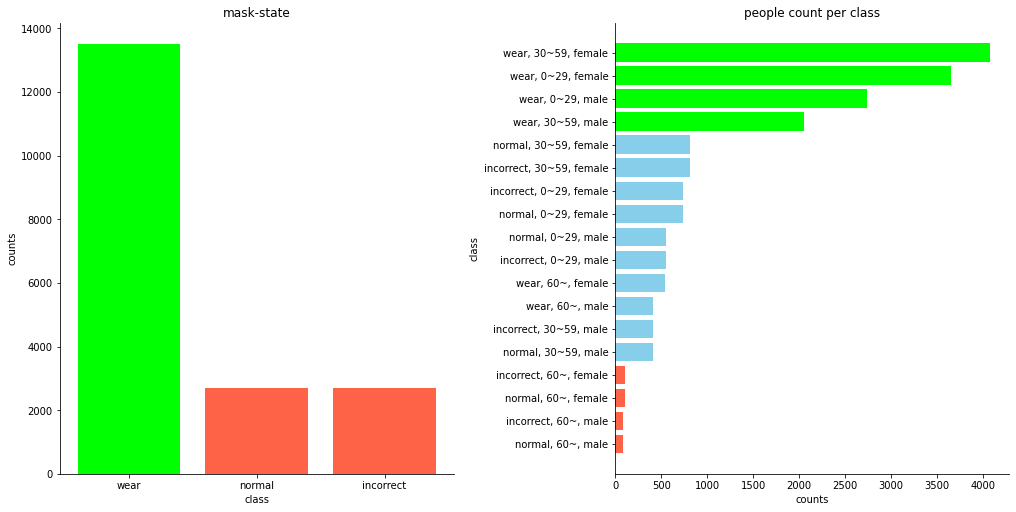

In [41]:
group_label = train_df["label"].value_counts().sort_values(ascending=True)
group_mask_state = train_df["mask_state"].value_counts()
fig, axes = plt.subplots(1,2,figsize=(14, 7), constrained_layout=True )
classes = []
for i in group_label.index:
    classes.append(label_to_info(i))
axes[0].bar([{2:"normal",1:"incorrect",0:"wear"}[x] for x in group_mask_state.index],group_mask_state, color = ["lime","tomato","tomato"])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_title("mask-state")
axes[0].set_xlabel("class")
axes[0].set_ylabel("counts")
axes[1].barh(classes,group_label, color = (["tomato"]*4+["skyblue"]*10+["lime"]*4))
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_ylabel("class")
axes[1].set_xlabel("counts")
axes[1].set_title("people count per class")
plt.show()

# Day2 custom dataset & data loader

# 데이터 셋

- 성별, 나이대, 마스크 착용 여부를 따로 학습 시킬 수도 있을 것 같아서 생성자에 학습시킬 라벨 정보를 입력받게 해줌

In [16]:
class maskDataset(Dataset):
    def __init__(self, train_df, label = "label", train = True):
        self.X = train_df['path']
        self.y = train_df[label]
        self.train = train
    def __len__(self):
        return self.y.size
    def __getitem__(self, idx):
        X = transforms.ToTensor()(Image.open(self.X.iloc[idx]))
        y = self.y.iloc[idx]
        if self.train:
            return X, y
        else:
            return X

In [17]:
train_df = pd.read_csv("/opt/ml/path_csv/image_path_label.csv")
mask_dataset_train = maskDataset(train_df.iloc[:int(0.8*2700*7),:])
mask_dataset_val = maskDataset(train_df.iloc[int(0.8*2700*7):,:])

In [71]:
len(mask_dataset_val)

3780

In [19]:
import random

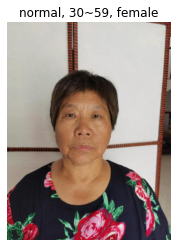

In [20]:
from torchvision.transforms.functional import to_pil_image
randn = random.randrange(15120)
image_tensor, label = mask_dataset_train[randn]
plt.imshow(to_pil_image(image_tensor))
plt.title(label_to_info(label))
plt.axis('off')
plt.show()

In [21]:
next(iter(DataLoader(mask_dataset_train)))

[tensor([[[[0.7490, 0.7490, 0.7490,  ..., 0.7882, 0.7882, 0.7882],
           [0.7490, 0.7490, 0.7490,  ..., 0.7882, 0.7882, 0.7882],
           [0.7490, 0.7490, 0.7490,  ..., 0.7882, 0.7882, 0.7882],
           ...,
           [0.5843, 0.5882, 0.5882,  ..., 0.5922, 0.5922, 0.5922],
           [0.5725, 0.5725, 0.5725,  ..., 0.5961, 0.5961, 0.5961],
           [0.5608, 0.5608, 0.5608,  ..., 0.6078, 0.6078, 0.6078]],
 
          [[0.7451, 0.7451, 0.7451,  ..., 0.7843, 0.7843, 0.7843],
           [0.7451, 0.7451, 0.7451,  ..., 0.7843, 0.7843, 0.7843],
           [0.7451, 0.7451, 0.7451,  ..., 0.7843, 0.7843, 0.7843],
           ...,
           [0.3804, 0.3843, 0.3843,  ..., 0.3686, 0.3686, 0.3686],
           [0.3686, 0.3686, 0.3686,  ..., 0.3725, 0.3725, 0.3725],
           [0.3569, 0.3569, 0.3569,  ..., 0.3686, 0.3686, 0.3686]],
 
          [[0.7255, 0.7255, 0.7255,  ..., 0.7647, 0.7647, 0.7647],
           [0.7255, 0.7255, 0.7255,  ..., 0.7647, 0.7647, 0.7647],
           [0.7255, 0.72

In [22]:
dataloader_train_mask = DataLoader(mask_dataset_train,
                                   batch_size = 16,
                                   shuffle = True,
                                   num_workers = 2)
dataloader_val_mask = DataLoader(mask_dataset_val,
                                   batch_size = 16,
                                   shuffle = False,
                                   num_workers = 2)

In [23]:
images, labels = next(iter(dataloader_train_mask))

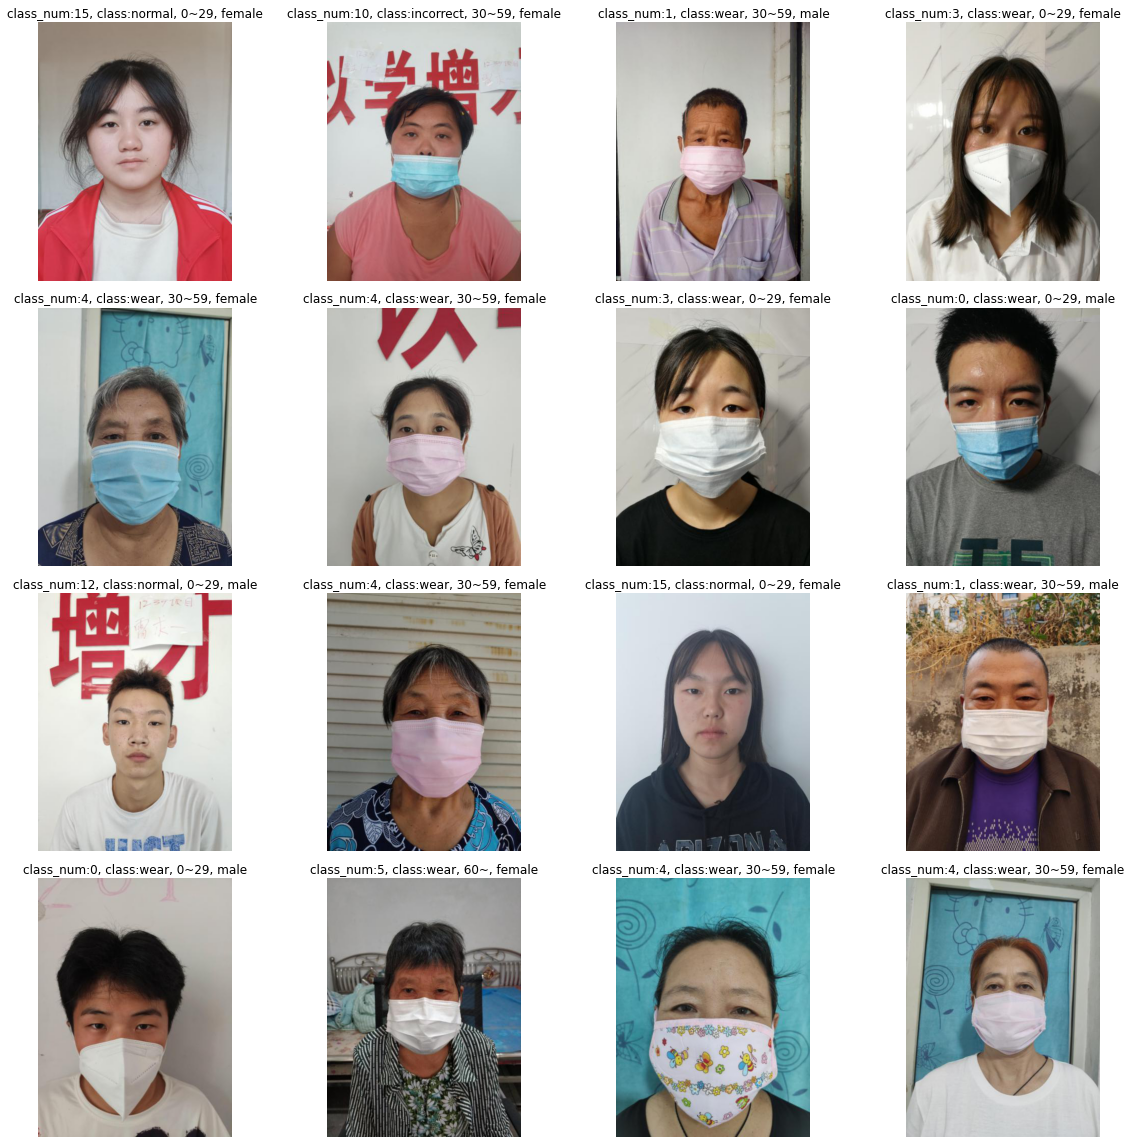

In [24]:
plt.figure(figsize=(16,16))
for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot(4,4,n)
    plt.imshow(to_pil_image(image))
    plt.title("class_num:{}, class:{}".format(label,label_to_info(int(label))))
    plt.axis('off')
plt.tight_layout()
plt.show()    

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize


In [26]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
print("네트워크 필요 입력 채널 개수", efficientnet.stem.conv.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", efficientnet.classifier.fc.weight.shape[0])

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 1000


Using cache found in /opt/ml/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/opt/ml/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/opt/ml/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [27]:
efficientnet.classifier.fc = torch.nn.Linear(in_features=1280, out_features=18, bias=True) 
torch.nn.init.xavier_uniform_(efficientnet.classifier.fc.weight)
stdv = 1.0/np.sqrt(512)
efficientnet.classifier.fc.bias.data.uniform_(-stdv, stdv)
print("네트워크 필요 입력 채널 개수", efficientnet.stem.conv.weight.shape[1])
print("네트워크 출력 채널 개수 (예측 class type 개수)", efficientnet.classifier.fc.weight.shape[0])

네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 18


In [28]:
from tqdm import tqdm

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"{device} is using!")

efficientnet.to(device)

LEARNING_RATE = 0.0001
NUM_EPOCH = 5

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=LEARNING_RATE)
dataloaders = {
    "train" : dataloader_train_mask,
    "test" : dataloader_val_mask
}

cuda:0 is using!


In [30]:
import torch.nn.functional as F
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
  for phase in ["train", "test"]:
    running_loss = 0.
    running_acc = 0.
    if phase == "train":
      efficientnet.train()
    elif phase == "test":
      efficientnet.eval()

    for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
      images = images.to(device)
      labels = labels.cuda()
      optimizer.zero_grad()
      
      with torch.set_grad_enabled(phase == "train"):
        logits = efficientnet(images)
        _, preds = torch.max(logits, 1)
        loss = loss_fn(logits, labels)
        if phase == "train":
          loss.backward()
          optimizer.step() 
    
      running_loss += loss.item() * images.size(0) 
      running_acc += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
    if phase == "test" and best_test_accuracy < epoch_acc: 
      best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: 
      best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.577, 평균 Accuracy : 0.833


  0%|          | 0/945 [00:00<?, ?it/s]

현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.442, 평균 Accuracy : 0.848


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.117, 평균 Accuracy : 0.966


  0%|          | 0/945 [00:00<?, ?it/s]

현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.365, 평균 Accuracy : 0.915


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.052, 평균 Accuracy : 0.986


  0%|          | 0/945 [00:00<?, ?it/s]

현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.428, 평균 Accuracy : 0.900


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.031, 평균 Accuracy : 0.991


  0%|          | 0/945 [00:00<?, ?it/s]

현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.432, 평균 Accuracy : 0.916


  0%|          | 0/237 [00:00<?, ?it/s]

현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.021, 평균 Accuracy : 0.995


100%|██████████| 237/237 [00:12<00:00, 18.28it/s]

현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.558, 평균 Accuracy : 0.880
학습 종료!
최고 accuracy : 0.9161375761032104, 최고 낮은 loss : 0.36472498238325074


image class is incorrect, 0~29, female
this model predicted incorrect, 0~29, female
정답


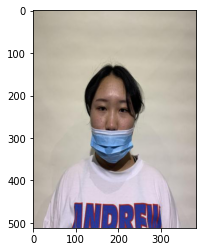

In [57]:
IMAGE_INDEX = random.randrange(3780) 
plt.imshow(to_pil_image(mask_dataset_val[IMAGE_INDEX][0]))
print(f"image class is {label_to_info(mask_dataset_val[IMAGE_INDEX][1])}")
logits = efficientnet(mask_dataset_val[IMAGE_INDEX][0].unsqueeze(0).to(device))
_, preds = torch.max(logits, 1)
print(f"this model predicted {label_to_info(int(preds))}")
if int(preds) == mask_dataset_val[IMAGE_INDEX][1]:
    print("정답")
else:
    print("오답")